<h1>Простая нейронная сеть на PyTorch своими руками</h1>


# Обучение нейронной сети с использованием PyTorch

В этом задании нужно построить и обучить простую нейронную сеть с помощью PyTorch.

In [1]:
import torch



## Подготовка датасета

Здесь мы узнаем некоторые базовые функции и классы подготовки данных из **PyTorch** как:

- `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`
- dataset downloading api

Для начала мы определим нашу проблему. Здесь мы загружаем набор данных MNIST (с PyTorch API)

MNIST:
- 28x28 изображений из рукописных цифр
- каждый пиксель серый (float value in [0, 1))
- targets — это целое значение в диапазоне [0, 9] (10 классов)
- объекты ($x_i$, $y_i$), где $x_i$ размера (1, 28, 28), $y_i$ это значение int

Для использования на входе полносвязной нейронной сети входные данные ($ x $) преобразуем в одномерный массив, чтобы наши данные во время обучения имели формы:

- `x_batch` размера `(batch_size, 784)`
- `y_batch` размера `(batch_size)`



In [2]:
from torchvision.datasets import MNIST
import torchvision.transforms as tfs

In [3]:
data_tfs = tfs.Compose([
  tfs.ToTensor(),
  tfs.Normalize((0.5), (0.5))
])

In [4]:
# install for train and test
root = './'
train = MNIST(root, train=True,  transform=data_tfs, download=True)
test  = MNIST(root, train=False, transform=data_tfs, download=True)

In [5]:
print(f'Data size:\n\t train {len(train)},\n\t test {len(test)}')
print(f'Data shape:\n\t features {train[0][0].shape},\n\t target {type(test[0][1])}')

Data size:
	 train 60000,
	 test 10000
Data shape:
	 features torch.Size([1, 28, 28]),
	 target <class 'int'>


Нам не нужно реализовывать batch loader самостоятельно, воспользуемся его реализацией в torch, которая называется `DataLoader` из `torch.utils.data`.

In [6]:
from torch.utils.data import DataLoader

batch_size = 128

train_loader = DataLoader(train, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, drop_last=True)

In [7]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

## Модель и обучение

Далее построим однослойную нейронную сеть для классификации изображений. В цикле обучения будем вычислять loss через кросс-энтропию от X @ W + b и правильных ответом. Далее с помощью loss.backward() вычислим градиенты и обновим веса в сети.

In [8]:
features = 784
classes = 10

Создайте вещественный тензор W размером (features, classes) и вектор B размером (classes)
и заполните небольшими случайными значениями из нормального распределения (можно использовать uniform)
Укажите, что для W и B нужно вычислять градиент:

In [9]:
W = torch.rand((features, classes), requires_grad=True)
B = torch.rand((classes), requires_grad=True)

Зададим параметры градиентного спуска:

In [10]:
# количество эпох обучения
epochs = 4

# learning_rate - скорость обучения
lr=1e-2      

# массив для сохранения истории вычисления функции потерь
history = []

Кросс-энтропия в PyTorch берется от логитов (выходов нейронов), а не от вероятностей,
поэтому функцию активации softmax использовать не нужно

In [11]:
import numpy as np
from torch.nn.functional import cross_entropy

for i in range(epochs):
    #цикл по батчам в одной эпохе
    for x_batch, y_batch in train_loader:
        # загружаем батч данных (вытянутый в линию)
        x_batch = x_batch.reshape(x_batch.shape[0], -1)

        # TODO: вычислите значение функции потерь 
        # и сохраните в history
        y_pred = x_batch @ W + B
        loss = cross_entropy(
            input=y_pred,
            target=y_batch,
        )
        history.append(loss)
        
        # TODO: вычислите градиенты
        loss.backward()
        
        # TODO: сделайте шаг градиентного спуска
        # можно использовать with torch.no_grad() 
        # во время обновления весов для ускорения вычислений
        with torch.no_grad():
            W -= 0.05 * W.grad.data
            B -= 0.05 * B.grad.data
        
        # TODO: обнулите градиенты
        W.grad.data.zero_()
        B.grad.data.zero_()
        
    print(f'{i+1},\t loss: {history[-1]}')

1,	 loss: 0.14611051976680756
2,	 loss: 0.11120446771383286
3,	 loss: 0.09825913608074188
4,	 loss: 0.08926647156476974


Построим график для loss (функции потерь) во время обучения.

In [12]:
import matplotlib.pyplot as plt

history_detached = list(
    map(lambda x: x.detach().numpy(), history)
)
# print(history_detached)

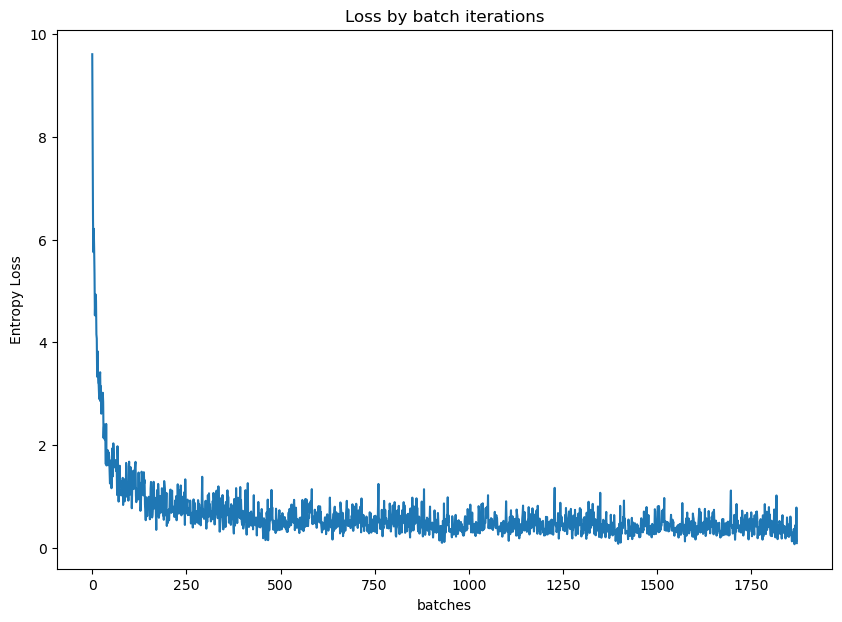

In [13]:
plt.figure(figsize=(10, 7))

plt.plot(history_detached)

plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')

plt.show()

Посмотрим некоторые показатели качества для нашей линейной модели

In [14]:
from sklearn.metrics import accuracy_score

Посчитайте accuracy_score по всем батчам из test_loader.

Для получения предсказаний сети можно использовать torch.argmax от выходов нейронной сети

In [15]:
for x_batch, y_batch in test_loader:
    x_batch = x_batch.reshape(x_batch.shape[0], -1)

    y_pred = x_batch @ W + B
    
    accuracy = accuracy_score(torch.argmax(y_pred, dim=1), y_batch)
    print(accuracy)

0.921875
0.9140625
0.8671875
0.8125
0.8125
0.8671875
0.890625
0.8359375
0.8515625
0.78125
0.84375
0.7734375
0.84375
0.8203125
0.8515625
0.8203125
0.8828125
0.875
0.8359375
0.90625
0.828125
0.890625
0.890625
0.875
0.8359375
0.8359375
0.8828125
0.8203125
0.9140625
0.7734375
0.859375
0.8203125
0.8515625
0.8671875
0.8671875
0.8671875
0.8984375
0.84375
0.8203125
0.90625
0.9296875
0.9453125
0.984375
0.8671875
0.859375
0.921875
0.8828125
0.828125
0.9453125
0.9609375
0.90625
0.8125
0.8984375
0.9375
0.9296875
0.96875
0.953125
0.9609375
0.890625
0.9609375
0.9375
0.828125
0.9375
0.9453125
0.90625
0.9375
0.96875
0.96875
1.0
0.984375
0.9140625
0.9375
0.9609375
0.953125
0.9375
0.8671875
0.8046875
0.796875
